# BERT MODEL

"Bidirectional" aspect of BERT means that it doesn't read text like a book (one page at a time) but rather like a person who can read and understand a sentence by considering both what came before and what comes after each word.

# Reading Files (Test-Train-Validation)

In [ ]:
!pip install requests

In [2]:
import pandas as pd
from PIL import Image
from torchvision import transforms
import os
import time
import torch
import requests
from io import StringIO

In [3]:
# Read the dataframe
url1 = "https://drive.google.com/uc?id=1eyUZPqxU1H-heqZHFhQ74hqp5rlBLWsA"
response1 = requests.get(url1)
train_df = pd.read_csv(StringIO(response1.text))

url2 = "https://drive.google.com/uc?id=1eX9AKnj2ALQt9dD3n_UcFGe3mO7uXuiS"
response2 = requests.get(url2)
test_df = pd.read_csv(StringIO(response2.text))

url3 = "https://drive.google.com/uc?id=17f9oKnzUBI_5EaL_cg40zdL6eneWxZNY"
response3 = requests.get(url3)
val_df = pd.read_csv(StringIO(response3.text))

train_text= train_df['clean_comments'].values
test_text= test_df['clean_comments'].values
val_text=val_df['clean_comments'].values

train_labels= train_df['scenic'].values
test_labels= test_df['scenic'].values
val_label= val_df['scenic'].values

In [ ]:
train_df

In [ ]:
train_text[:5]

array(['northern end long mountain', 'looking north',
       'old railway line used farm road remnant previous road bridge farm',
       'clump tree teampan', 'looking north west'], dtype=object)

# Bert- Base -Uncased Model

We will use "BertForSequenceClassification". This is the normal BERT model with an added Single layer on top will be binary classification for sentences.

In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.6 MB/s eta 0:00:00


In [5]:
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Tokenizing the first text as an example.

In [ ]:
print(' Original sentence: ', train_text[0])
print('Tokenized sentence: ', tokenizer.tokenize(train_text[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0])))

 Original sentence:  northern end long mountain
Tokenized sentence:  ['northern', 'end', 'long', 'mountain']
Token IDs:  [2642, 2203, 2146, 3137]


In [6]:
# Calculate the maximum word count
max_word_count = max([len(text.split()) for text in train_text])
print("Maximum word count:", max_word_count)

Maximum word count: 201


#Tokenising

- To avoid subword parameter we split the text first.  

- In this example, the tokenizer.encode method is modified to include padding using the padding='max_length' argument and specifying a maximum length of 64 tokens (max_length=64). The torch.tensor conversion ensures that all sequences have the same length by padding them with zeros.  

- Truncation used to shortening a text to the length. This is necessary because models  require input size of 100. If a text is too long, it is going to be truncated. After, by padding all other texts to max_length we making sure that all texts are in the same length.

In [8]:
# Word-level tokenization using whitespace tokenizer
train_tokens_word_level = [text.split()[:364] for text in train_text]

# BERT tokenization on word-level tokens
train_tokens_bert = [tokenizer.encode(text, truncation=True, padding='max_length', max_length=100) for text in train_tokens_word_level]

train_tokens_before_padding = [tokenizer.encode(text, truncation=True, padding=True) for text in train_tokens_word_level]

In [9]:
# splitted into tokens
print('Sentence: ', train_text[1000])
# mapped
print('Tokens: ', train_tokens_bert[1000])

Sentence:  pair heavy horse dwarf shetland pony croft west town baras
Tokens:  [101, 3940, 3082, 3586, 11229, 25552, 15606, 28983, 2225, 2237, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Choosing "max_length"

Since significant amount of text less then 100 words, we chosed 100 as padding length.

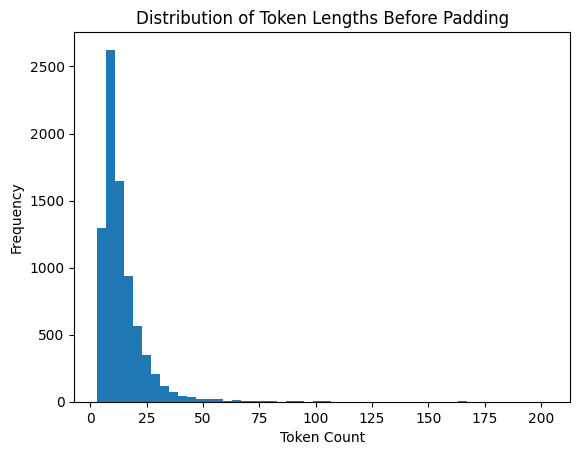

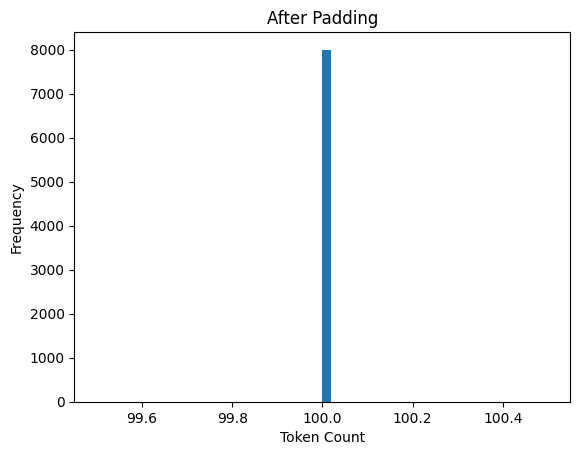

In [ ]:
# Calculate the lengths of tokenized sequences
token_lengths_after_padding = [len(tokens) for tokens in train_tokens_bert]
token_lengths_before_padding = [len(tokens) for tokens in train_tokens_before_padding]

plt.hist(token_lengths_before_padding, bins=50)
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths Before Padding')
plt.show()

# Plot the distribution of token lengths after padding
plt.hist(token_lengths_after_padding, bins=50)
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('After Padding')
plt.show()

# PREPEARING THE TOKENS/ TEST-TRAIN INPUTS

In [10]:
import torch.optim as optim
import torch.nn.functional as F

input_train = {
    'input_ids': torch.tensor([tokens for tokens in train_tokens_bert]),
    #'attention_mask': torch.tensor([[1] * len(tokens) for tokens in train_tokens]),
    'labels': torch.tensor(train_labels)
}

In [11]:
# Word-level tokenization using whitespace tokenizer
test_tokens_word_level = [text.split()[:364] for text in test_text]

# BERT tokenization on word-level tokens
test_tokens_bert = [tokenizer.encode(text, truncation=True, padding='max_length', max_length=100) for text in test_tokens_word_level]

test_inputs = {
    'input_ids': torch.tensor([tokens for tokens in test_tokens_bert]),
    #'attention_mask': torch.tensor([[1] * len(tokens) for tokens in test_tokens]),
    'labels': torch.tensor(test_labels)
}

# Creating Dataloader

In [12]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader, SequentialSampler

#Creating the DataLoader which will help us to load data into the GPU/CPU
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(input_train['input_ids'], input_train["labels"])
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(test_inputs['input_ids'], test_inputs["labels"])
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#  MODEL PARAMETERS

We will use "BertForSequenceClassification". We add single layer on top for binary classification.

In [28]:
#Loading the pre-trained BERT model from huggingface library

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = True,
    # each input token in relation to other tokens during the model's processing
    output_hidden_states = False, )

# run gpu, else turn original source
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


"BertForSequenceClassification"

**Word Embeddings:** This part converts words into numbers. It understands a vocabulary of 30,522 words and represents each word as a 768-number vector.  

**Positional Embeddings:** It keeps track of where each word is in a sentence.  

**Token Type Embeddings:** Helps understand different parts of text if there are multiple segments.  

**Layer Normalization and Dropout:** These are used to make the model more stable and prevent overfitting.  

**BertPooler:** It summarizes all the information from the 12 layers into a fixed-size representation.  

**Dropout:** Another step to prevent overfitting.  

**Classifier:** Finally, it uses this summarized information to decide if a given text falls into one of two categories (binary classification). This is done using a linear layer.

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [14]:
adamw_optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# LEARNING RATE SCHEDULER

In [15]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# num training steps = num batches * num epochs.
step_num = len(train_dataloader) * epochs

# Create the learning rate scheduler. Dnum_warmup_steps used as default
learning_rate_scheduler = get_linear_schedule_with_warmup(adamw_optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = step_num)

# ACCURACY FUNTION AND TIMING

In [17]:
import numpy as np
import time
import datetime

# calculating the accuracy of our predictions vs labels
def accuracy_print(predictions, label):
    pred_last = np.argmax(predictions, axis=1).flatten()
    labels_last = label.flatten()
    return np.sum(pred_last == labels_last) / len(labels_last)

#Creating the helper function to have a watch on elapsed time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np
import torch
import time

# Set a random seed for reproducibility.
seed_value = 42

# Set random seeds for libraries
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Store the average loss after each epoch.
loss_values = []
# Define the number of training epochs.
epochs = 4  # Change this to your desired number of epochs

# For each epoch...
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print("Training in progress...")

    # Measure how long the training epoch takes.
    start_time = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and step != 0:
            elapsed_time = format_time(time.time() - start_time)

        input_ids = batch[0].to(device)
        labels = batch[1].to(device)

        model.zero_grad()
        outputs = model(input_ids, token_type_ids=None, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        adamw_optimizer.step()
        learning_rate_scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print(f"training loss: {avg_train_loss:.2f}")
    print(f"epoch time: {format_time(time.time() - start_time)}")
    print("\nRunning Validation...")

    start_time = time.time()

    model.eval()

    loss_evaliation, accuracy_evaliation = 0, 0
    steps_evaliation = 0

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)

        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        accuracy_tmpevaliation = accuracy_print(logits, label_ids)

        accuracy_evaliation += accuracy_tmpevaliation
        steps_evaliation += 1

    print(f"Validation accuracy: {accuracy_evaliation / steps_evaliation:.2f}")
    print(f"Validation duration: {format_time(time.time() - start_time)}")

print("\nTraining is complete!")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/4
Training in progress...
training loss: 0.57
epoch time: 0:01:02

Running Validation...
Validation accuracy: 0.80
Validation duration: 0:00:02
Epoch 2/4
Training in progress...
training loss: 0.41
epoch time: 0:00:45

Running Validation...
Validation accuracy: 0.80
Validation duration: 0:00:02
Epoch 3/4
Training in progress...
training loss: 0.36
epoch time: 0:00:44

Running Validation...
Validation accuracy: 0.80
Validation duration: 0:00:02
Epoch 4/4
Training in progress...
training loss: 0.30
epoch time: 0:00:44

Running Validation...
Validation accuracy: 0.81
Validation duration: 0:00:02

Training is complete!


In [ ]:
print(loss_values)

[0.5513981499671936, 0.41804606044292447, 0.35375541895627977, 0.2907858310639858]


# Save The Model

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
# Define the path for saving the model
model_path = '/content/drive/MyDrive/deneme/bert_delete'

# Save the model
model.save_pretrained(model_path)
"""

# load The model

In [29]:
# Define the URL where your model weights (state_dict) are hosted
WEIGHTS_URL = 'https://fypphotos.s3.amazonaws.com/pytorch_model.bin'

# Define a local file path to save the downloaded weights
LOCAL_WEIGHTS_PATH = 'pytorch_model.bin'

# Download the model weights from the URL
torch.hub.download_url_to_file(WEIGHTS_URL, LOCAL_WEIGHTS_PATH)

# Load the saved weights into the model
model.load_state_dict(torch.load(LOCAL_WEIGHTS_PATH, map_location='cpu'))

100%|██████████| 418M/418M [00:07<00:00, 59.3MB/s]


<All keys matched successfully>

In [ ]:
model

In [18]:
# Google Cloud saved model
'''
!pip install gdown
import gdown

model_url="https://drive.google.com/uc?id=1-8o8MZTEdvEHgX62vc512S6uKRDesLX6"
output = 'pytorch_model.bin'
gdown.download(model_url, output, quiet=False)
state_dict = torch.load(output)
model.load_state_dict(state_dict)

In [ ]:
"""
# Load the saved model
model_path = '/content/drive/MyDrive/deneme/bert_final'
model = BertForSequenceClassification.from_pretrained(model_path)
"""

# Prediciton

for training process training_text and test_text used with trainining and validation names. For validation process we will use validation_text with validation name.

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import gdown

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [48]:
# Word-level tokenization using whitespace tokenizer
validation_tokens_word_level = [text.split()[:364] for text in val_text]

# BERT tokenization on word-level tokens
validation_tokens_bert = [tokenizer.encode(text, truncation=True, padding='max_length', max_length=100) for text in validation_tokens_word_level]

validation_inputs = {
    'input_ids': torch.tensor([tokens for tokens in validation_tokens_bert]).to(device),
    #'attention_mask': torch.tensor([[1] * len(tokens) for tokens in test_tokens]),
    'labels': torch.tensor(val_label).to(device)
    #'labels': torch.tensor(test_labels.values)  # Convert test_labels to a numpy array using the 'values' attribute
}

In [24]:
len(validation_inputs['input_ids'])

1000

In [ ]:
batch_size = 16
outputs = []

# Set the model to evaluation mode
model.eval()

# Move the model to the same device as the input tensors (if not already on the same device)
model.to(device)

# Get the number of batches
num_batches = len(validation_inputs['input_ids']) // batch_size

# Start the timer
start_time = time.time()

for i in range(0, len(validation_inputs['input_ids']), batch_size):
    batch_inputs = {
        'input_ids': validation_inputs['input_ids'][i:i+batch_size].to(device)
    }

    with torch.no_grad():
        batch_output = model(**batch_inputs)
        outputs.extend(batch_output.logits.cpu().numpy())

    # Calculate elapsed time for this batch
    elapsed_time = time.time() - start_time

    # Calculate estimated total time
    estimated_total_time = elapsed_time / (i + 1) * num_batches

    # Print the estimated time for completion after each batch
    print(f"Batch {i//batch_size + 1}/{num_batches}, Estimated Total Time: {estimated_total_time:.2f} seconds")

# End of inference
print("Inference completed!")


#CONFUSION MATRIX AND ACCURACY SCORE

In [49]:
predicted_labels = np.argmax(outputs, axis=1)
# Convert logits to class labels
true_labels = val_label
# test_labels is a numpy array or list of true labels

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

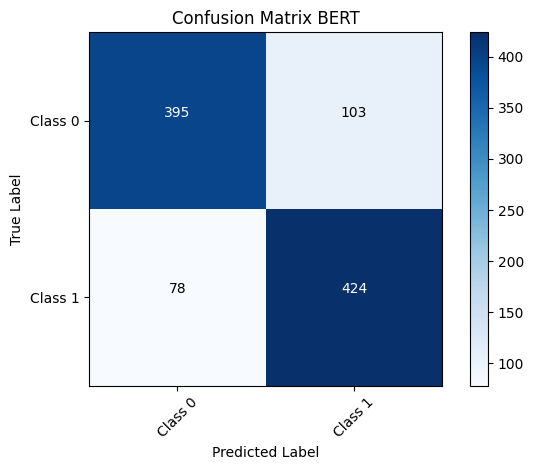

Accuracy: 0.82


In [50]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix BERT', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations for TP, TN, FP, FN counts
    thresh = cm.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f'{cm[i, j]}\n', ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

# we have a list of class names 'class_names'
class_names = ['Class 0', 'Class 1']
plot_confusion_matrix(cm, class_names)
plt.show()

print(f"Accuracy: {accuracy:.2f}")

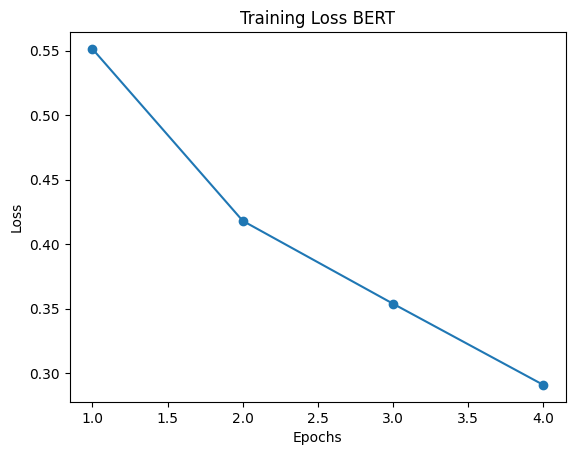

In [ ]:
# Plotting the loss
epochs = range(1, epochs+1)

plt.plot(epochs, loss_values, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss BERT')
plt.show()

In [37]:
f1_score(true_labels, predicted_labels, average='macro')
f1_score(true_labels, predicted_labels, average='micro')
f1_score(true_labels, predicted_labels, average='weighted')
f1_score(true_labels, predicted_labels, average=None)

array([0.81359423, 0.82410107])

In [38]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       498
           1       0.80      0.84      0.82       502

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



**Class 0** has a higher precision, indicating that the model is cautious when predicting Class 0, and it tends to make fewer false positive errors for Class 0.  

**Class 1** has a higher recall, indicating that the model is better at capturing most of the actual positive instances (Class 1) in the dataset, but it may have a slightly higher false positive rate for Class 1.  

***F1 SCORES***

For Class 0 (negative class), the F1-score is 0.81.  
For Class 1 (positive class), the F1-score is 0.82.  

These F1 scores indicate the following:

This suggests that the model is performing slightly better in terms of a balance between precision and recall for Class 1. In other words, when it comes to the positive class (Class 1), the model is slightly more effective at both making accurate positive predictions (precision) and capturing actual positive instances (recall).

**Balanced Performance:** The F1 scores for both classes are relatively close to each other (0.81 for Class 0 and 0.82 for Class 1). This suggests that the model is achieving a balanced performance in terms of precision and recall for both the negative (Class 0) and positive (Class 1) classes.  

**Overall Model Effectiveness:** An F1-score in the range of 0.8 is often considered a good performance in binary classification tasks. It indicates that the model is effective at both making accurate positive predictions (precision) and capturing actual positive instances (recall) for both classes.  

**Similar Performance:** The fact that the F1-scores for both classes are close indicates that the model does not favor one class significantly over the other. It's achieving a reasonably good balance between avoiding false positives and capturing true positives for both classes.  

In summary, the F1 scores you provided suggest that the model is performing well in terms of precision and recall for both classes, and it's achieving a balanced performance in the binary classification task. This is a positive indicator of the model's effectiveness in making accurate predictions for both positive and negative instances.

# QUALITATIVE ANALYSIS

In [39]:
!pip install gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1-39gatpZL3__lLx3CY90jJFqLxPQ3w8q'
output = 'selected_cases.csv'
gdown.download(url, output, quiet=False)

In [41]:
dataset_qualitative= pd.read_csv("selected_cases.csv")
input_qualitative=dataset_qualitative['clean_comments'].values
label_qualitative=dataset_qualitative["scenic"].values

In [42]:
# Word-level tokenization using whitespace tokenizer
qual_tokens_word_level = [text.split()[:364] for text in input_qualitative]

# BERT tokenization on word-level tokens
qual_tokens_bert = [tokenizer.encode(text, truncation=True, padding='max_length', max_length=100) for text in qual_tokens_word_level]

In [43]:
# Print the sentence split into tokens.
print('Sentence: ', input_qualitative)
# Print the sentence mapped to token ids.
print('Tokens: ', qual_tokens_bert[0])

Sentence:  ['gully waist deep heather feed black burn scottish side knox knowe distinctly evil foot english side tough enough isolated outcrop boulder fell sandstone add fun'
 'west dart head isolated place within grassy wilderness inner dartmor probably often visited tranquil seems far away rest devon sunny day ideal place spend time rain mist would atmosphere'
 'could road like yorkshire valley clogged buildings whereas blackwater valley wa relatively clear road ha built cutting embankment fence side lake wood valley still enjoyed photo wa taken looking northward footbridge accessed shawfield lane'
 'located next m62 huge ikea store gemini retail park \\nthe warington store cover area 270 sq mts wa first ikea open united kingdom 1987 \\ntoday 15 store dotted around united kingdom']
Tokens:  [101, 100, 5808, 2784, 9533, 5438, 2304, 6402, 4104, 2217, 11994, 100, 19517, 4763, 3329, 2394, 2217, 7823, 2438, 7275, 100, 13264, 3062, 11694, 5587, 4569, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [44]:
qual_inputs = {
    'input_ids': torch.tensor([tokens for tokens in qual_tokens_bert]),
    #'labels': torch.tensor(label_qualitative)
}

In [45]:
qual_outputs=[]
qual_output = model(**qual_inputs)
qual_outputs.extend(qual_output.logits.detach().numpy())

In [46]:
predicted_labels = np.argmax(qual_outputs, axis=1)  # Convert logits to class labels
true_labels = label_qualitative  # test_labels is a numpy array or list of true labels

# Calculate the confusion matrix
cm_qual = confusion_matrix(true_labels, predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

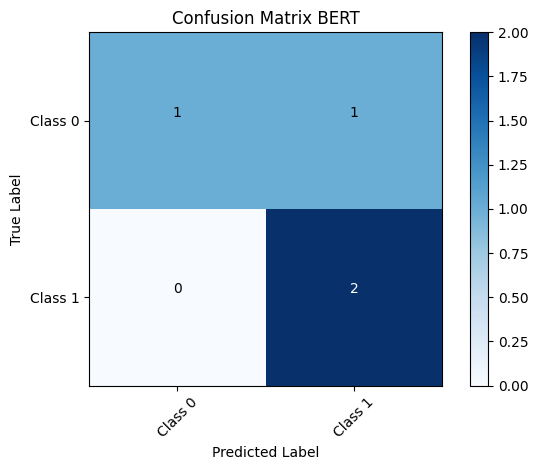

Accuracy: 0.75


In [47]:
# we have a list of class names 'class_names'
class_names = ['Class 0', 'Class 1']
plot_confusion_matrix(cm_qual, class_names)
plt.show()

print(f"Accuracy: {accuracy:.2f}")

In [43]:
# Initialize the decoded comments list
decoded_comments = []
for tokens in qual_tokens_bert:
    decoded_text = tokenizer.decode(tokens, skip_special_tokens=True)
    decoded_comments.append(decoded_text)

# Print comments with labels
for i in range(len(true_labels)):
    comment_text = decoded_comments[i]  # Using the decoded comments
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]

    label_status = "CORRECT" if true_label == predicted_label else "INCORRECT"

    print(f"Comment {i + 1} (Label Status: {label_status}):")
    #print(f"   Comment Text: {comment_text}")
    print(f"   True Label: {true_label}")
    print(f"   Predicted Label: {predicted_label}")
    if true_label!=predicted_label:
      print(f"   Comment Text: {comment_text}")
    print()

Comment 1 (Label Status: CORRECT):
   True Label: 1
   Predicted Label: 1

Comment 2 (Label Status: CORRECT):
   True Label: 1
   Predicted Label: 1

Comment 3 (Label Status: INCORRECT):
   True Label: 0
   Predicted Label: 1
   Comment Text: could road like yorkshire valley buildings whereas valley wa relatively clear road ha built cutting embankment fence side lake wood valley still enjoyed photo wa taken looking northward accessed lane

Comment 4 (Label Status: CORRECT):
   True Label: 0
   Predicted Label: 0



The model incorrectly predicted "Low Scenic (Average: 2.25)" data point as Class 1 (Positive) when the true label is Class 0 (Negative). The comment text contains phrases like "road like Yorkshire valley" and "buildings," which might have led the model to misinterpret it as positive. This suggests that the model may need to improve its understanding of context or specific phrases.

The model made correct predictions for three out of the four sample data points (Data Points 1, 2, and 4).
It incorrectly classified Data Point 3, misclassifying it as positive when it was actually negative.  

The model appears to perform reasonably well, with correct predictions for the majority of the sample data points.
It's important to note that qualitative analysis helps identify areas where the model may be making errors and provides insights into specific instances where it succeeded or failed in making predictions. In this case, the misclassification of Data Point 3 is an area to investigate further to understand why the model made an incorrect prediction and whether any improvements or adjustments to the model are necessary for better performance on similar cases.